In [1]:
import numpy as np
import os
import torch
import sys

from matplotlib import pyplot as plt
from torch import nn
from torchvision.transforms import Normalize,ToTensor, Compose

project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

from dataset import AnomalyMNIST
from experiments.utils.Supervised import SupervisedModel, train

AnomalyMNIST Dataset (Number of samples: 2400, Number of known anomalies: 200, Number of unknown anomalies: 200)


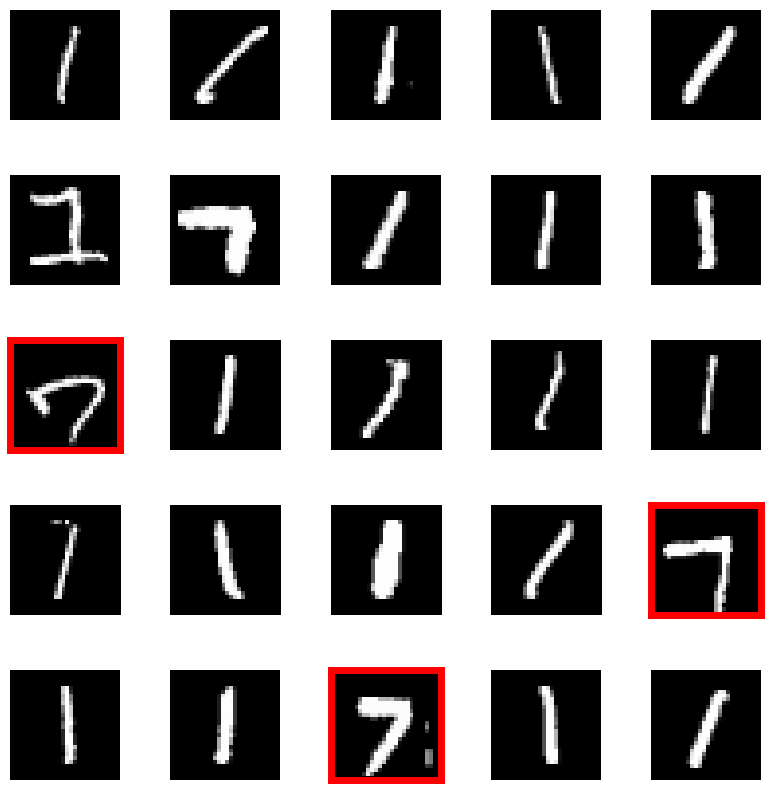

In [2]:
seed = 128
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

dataset = AnomalyMNIST('data/', download=True, transform=transform, n_normal_samples=2000, known_anomalies=0.1, pollution=0.1, seed=seed)
print(dataset)

dataset.montage(5, 5, seed)
plt.show()

In [3]:
model = SupervisedModel((28,28), [1, 16, 24], [1024, 256, 32, 2])
model = train(model, dataset, 128, 50, weighted_sampler=False)

KeyboardInterrupt: 

In [ ]:
# TODO: Include the test set configuration in the AnoamlyMNIST class
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Subset, DataLoader

test_dataset_full = MNIST('data/', train = False, download = True, transform = transform)
normal_idx = torch.where((test_dataset_full.targets == 1))[0]
anomaly_idx = torch.where((test_dataset_full.targets == 7))[0]
idx = torch.cat([normal_idx, anomaly_idx])

test_dataset_full.targets = torch.ones_like(test_dataset_full.targets) * -1
test_dataset_full.targets[normal_idx] = 0
test_dataset_full.targets[anomaly_idx] = 1

x_test_set = Subset(test_dataset_full, idx)

In [ ]:
# model.eval()
model.train()
x_test, y_test = zip(*x_test_set)
x_test = torch.stack(x_test)
y_test = torch.tensor(y_test)

y_score = model.score_samples(x_test)
# y_score = model(x_test).detach().numpy()[:,1]
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_score[:])


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
_y_score = torch.sigmoid(model.score_samples(x_test).flatten())
fpr, tpr, _ = roc_curve(y_test, y_score[:])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from matplotlib import pyplot as plt
plt.hist(_y_score[y_test==0], bins=10, alpha=0.5, label='Normal')
plt.hist(_y_score[y_test==1], bins=10, alpha=0.5, label='Anomaly')
plt.legend()
plt.show()

In [ ]:
# Classification report
# model.train()
model.eval()
from sklearn.metrics import classification_report
# y_pred = model(x_test).detach().argmax(dim=1)
y_pred = np.where(torch.sigmoid(model(x_test).detach()) > 0.5, 1, 0)
print(classification_report(y_test, y_pred, zero_division=1))

# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

In [ ]:
## Extract a 2 from the test dataset
model.eval()
number = 9
test2_dataset = MNIST('data/', train = False, download = True, transform=transform)
test2_idx = torch.where((test2_dataset.targets == number))[0]
test2_dataset = Subset(test2_dataset, test2_idx)

X, y = zip(*test2_dataset)
X = torch.stack(X)
y = torch.tensor(y).flatten()
# y_pred = model(X).detach().argmax(dim=1)
y_score = torch.sigmoid(model(X).detach())
y_pred = np.where(y_score > 0.5, 1, 0)

from matplotlib import pyplot as plt
plt.imshow(X[0,0])


In [ ]:
plt.subplot(1,2,1)
plt.hist(y_pred)
plt.subplot(1,2,2)
plt.hist(y_score)
plt.show()

In [ ]:
_y = np.ones_like(y)
np.bincount(y_pred == _y)

In [ ]:
x, y = zip(*[(_x, _y) for _x, _y in dataset])

x = torch.stack(x)
y = torch.tensor(y)

x0 = x[y==0]
x0_idx = torch.randperm(len(x0))[:100]
x0 = x0[x0_idx]
x1 = x[y==1]
x1_idx = torch.randperm(len(x1))[:100]
x1 = x1[x1_idx]

x = torch.cat([x0, x1])
y = torch.cat([torch.zeros(100), torch.ones(100)])

y_score = torch.sigmoid(model.score_samples(x)).flatten()
fpr, tpr, thresholds = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)

from matplotlib import pyplot as plt
plt.hist(y_score[y==0], bins=10, alpha=0.5, label='Normal')
plt.hist(y_score[y==1], bins=10, alpha=0.5, label='Anomaly')
plt.show()

In [ ]:
_y0_score = y_score[:100]

# get the idx of the highest 3 sigma
idx = torch.argsort(torch.tensor(_y0_score), descending=True)

plt.subplot(1, 3, 1)
plt.imshow(x0[idx[0]][0])
plt.title(_y0_score[idx[0]])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(x0[idx[1]][0])
plt.title(_y0_score[idx[1]])
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(x0[idx[2]][0])
plt.title(_y0_score[idx[2]])
plt.axis('off')

plt.show()

In [ ]:
_y1_score = y_score[100:]

# get the idx of the highest 3 _y1_score
idx = torch.argsort(torch.tensor(_y1_score), descending=False)

plt.subplot(1, 3, 1)
plt.imshow(x1[idx[0]][0])
plt.title(_y1_score[idx[0]])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(x1[idx[1]][0])
plt.title(_y1_score[idx[1]])
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(x1[idx[2]][0])
plt.title(_y1_score[idx[2]])
plt.axis('off')

plt.show()

# MedMNIST

In [4]:
import medmnist, torch
from medmnist import INFO, Evaluator
from medmnist.dataset import PneumoniaMNIST
import torch.utils.data as data

import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)


print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.2 @ https://github.com/MedMNIST/MedMNIST/


Using downloaded and verified file: data/pneumoniamnist.npz
AnomalyPneumoniaMNIST Dataset (Number of samples: 1395, Number of known anomalies: 121, Number of unknown anomalies: 60)


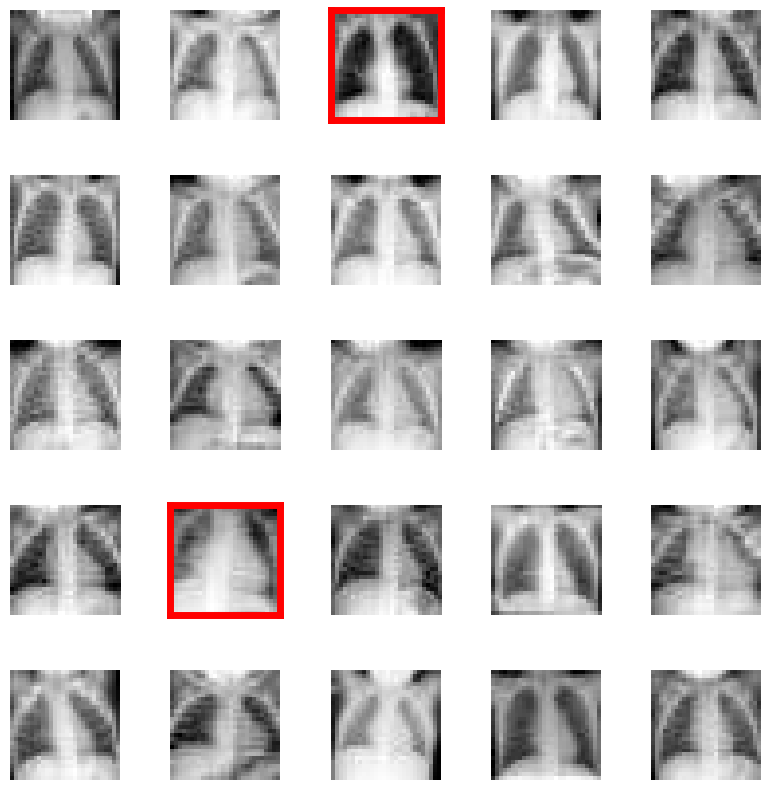

In [5]:
from dataset import AnomalyPneumoniaMNIST
from matplotlib import pyplot as plt
from torchvision import transforms

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
])

# Load the dataset
seed = 42
train_dataset = AnomalyPneumoniaMNIST('data/', download=True, transform=data_transform, n_normal_samples=-1, known_anomalies=0.1, pollution=0.05, seed=seed)
print(train_dataset)

train_dataset.montage(5, 5, seed)
plt.show()

In [6]:
BATCH_SIZE = 128
test_dataset = PneumoniaMNIST(split='test', transform=data_transform, download=True, root='data/')

train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=4*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: data/pneumoniamnist.npz


In [56]:
model = SupervisedModel((28,28), [1, 32, 48], [1024, 256, 32, 2])
model = train(model, train_dataset, 100, 100, weighted_sampler=False)

In [57]:
for param in model.parameters():
    param.requires_grad = False

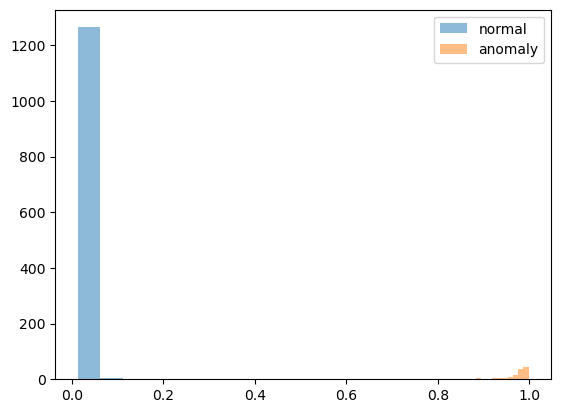

In [58]:
X, y = zip(*train_dataset)
X = torch.stack(X).detach()
y = torch.tensor(y)

y_score = model.score_samples(X)
plt.hist(y_score[torch.argwhere(y==0).squeeze()], bins=10, alpha=.5, label='normal')
plt.hist(y_score[torch.argwhere(y==1).squeeze()], bins=10, alpha=.5, label='anomaly')
plt.legend()
plt.show()

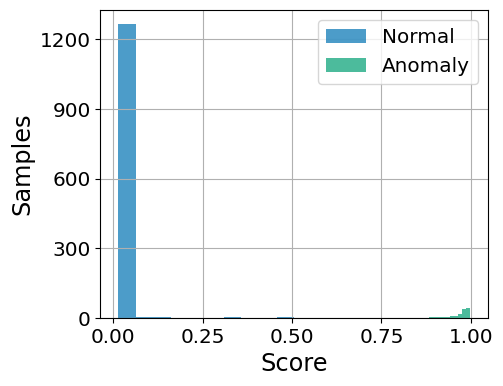

In [59]:
def generate_score_histogram(normal_score, anomaly_score, normal_bins=10, anomaly_bins=10):
    from matplotlib.ticker import MaxNLocator

    with plt.style.context('seaborn-colorblind'):
        fig = plt.figure(figsize=(5, 4))
        ax = plt.gca()
        ax.hist(normal_score, bins=normal_bins, alpha=.7, label='Normal')
        ax.hist(anomaly_score, bins=anomaly_bins, alpha=.7, label='Anomaly')
        ax.legend(fontsize='x-large')
        ax.xaxis.set_major_locator(MaxNLocator(nbins=5)) 
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.set_ylabel('Samples', fontsize='xx-large')
        ax.set_xlabel('Score', fontsize='xx-large')
        ax.tick_params(axis='both', which='major', labelsize='x-large')
        ax.grid()
        
        return fig

fig = generate_score_histogram(y_score[torch.argwhere(y==0).squeeze()], y_score[torch.argwhere(y==1).squeeze()])

In [60]:
model.eval()
# model.train()
x_test, y_test = zip(*test_dataset)
x_test = torch.stack(x_test)
y_test = torch.tensor(y_test).flatten()

# y_score = model(x_test).detach().numpy().mean(axis=1)
y_score = torch.sigmoid(model(x_test)).detach().numpy()
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_score[:])

0.902936664475126

In [61]:
y_score.shape
y_test.shape

torch.Size([624])

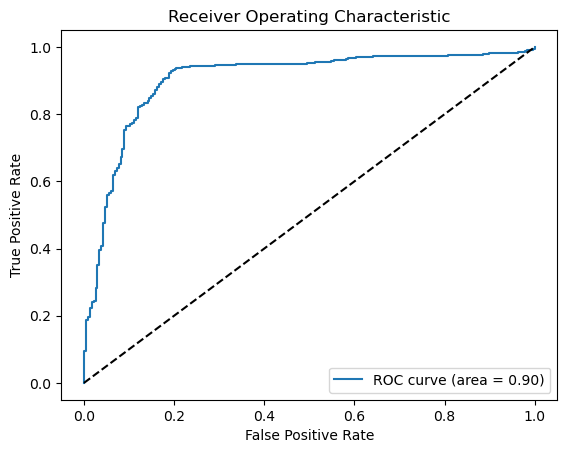

In [62]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
model.eval()
with torch.no_grad():
    y_score = model.score_samples(x_test.detach()).flatten()
    fpr, tpr, _ = roc_curve(y_test, y_score[:])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

/tmp/ipykernel_14076/399380385.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


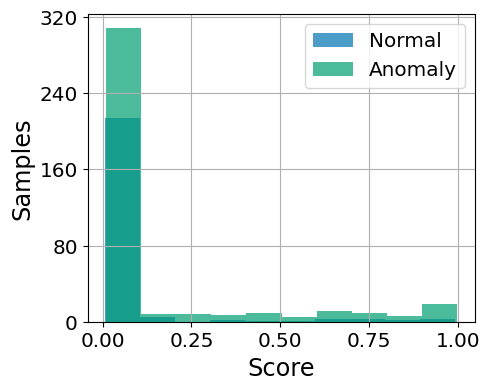

In [48]:
fig = generate_score_histogram(y_score[y_test==0], y_score[y_test==1])
fig.show()

fig.savefig('supervised_score_dropout.pdf', bbox_inches='tight')

In [31]:
# import pandas as pd
# path = '/media/abian/Extreme SSD/Thesis/Results/Chapter8/MedMNIST/Supervised/medmnist_anomalies_0.1_pollution_0.05/dropout/'

# fpr_tpr = []
# roc_auc = []
# for i in range(50):
#     with torch.no_grad():
#         y_score = model.score_samples(x_test).flatten()
#         fpr, tpr, _ = roc_curve(y_test, y_score[:])
#         fpr_tpr.append((fpr, tpr))
#         roc_auc.append(auc(fpr, tpr)) 

# fpr_tpr_df = pd.DataFrame(fpr_tpr, columns=['fpr', 'tpr'])  
# auc_df = pd.DataFrame(roc_auc, columns=['roc_auc'])

# fpr_tpr_df.to_pickle(os.path.join(path, 'fpr_tpr.pkl'))
# auc_df.to_csv(os.path.join(path, 'roc_auc.csv'))

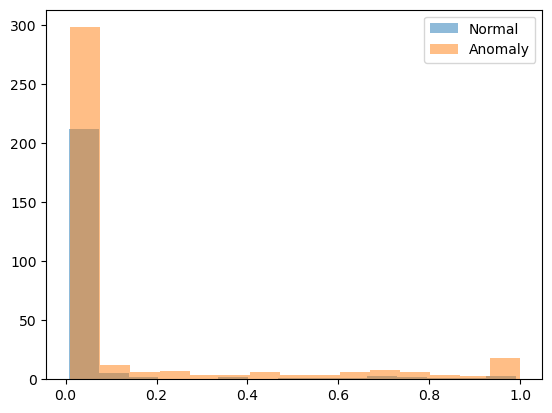

In [53]:
from matplotlib import pyplot as plt
plt.hist(y_score[y_test==0], bins=15, alpha=0.5, label='Normal')
plt.hist(y_score[y_test==1], bins=15, alpha=0.5, label='Anomaly')
plt.legend()
plt.show()

In [63]:
anoamlies_test = x_test[torch.argwhere(y_test == 1).squeeze()]

samples = [] 
with torch.no_grad():
    model.train()
    for i in range(50):
        _y = model.score_samples(x_test)
        samples.append(_y.detach())
        # result = torch.where(_y > 0.5, 1, 0).squeeze()
    
    samples = torch.stack(samples).detach()
    probs = samples.mean(dim=0).numpy()
    # entropy = - 1.0 * np.sum(probs * np.log(probs + 1e-16), axis=-1)

In [64]:
probs.shape

(624,)

/tmp/ipykernel_14076/1562473831.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


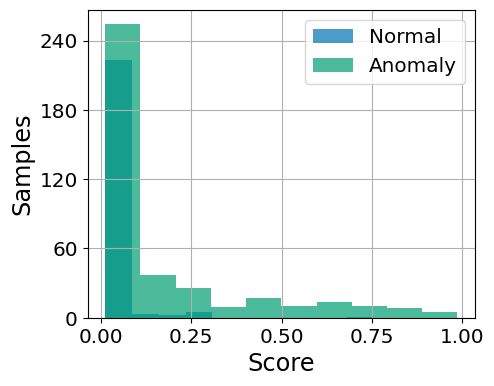

In [66]:
fig = generate_score_histogram(probs[y_test==0], probs[y_test==1])
fig.show()

fig.savefig('supervised_score_dropout.pdf', bbox_inches='tight')

In [ ]:
(0.1060 + 0.4019)/2

In [ ]:
import numpy as np
from scipy import stats

# Tus datos
data1 = y_score[y_test==0]
data2 = y_score[y_test==1]

# Realizar la prueba t
t_stat, p_value = stats.ttest_ind(data1, data2)

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")


In [ ]:
y_hat = torch.sigmoid(model(x_test))
y_hat = np.where(y_hat > 0.5, 1, 0)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat, target_names=('Normal', 'Anomaly'), zero_division=1))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_hat)

In [ ]:
np.bincount(y_test), np.bincount(y_hat)

In [ ]:
import os
import sys

project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)


from experiments.MedMNIST import ExperimentSupervised

experiment = ExperimentSupervised(0.1, 0.05)

In [ ]:
experiment.run()

In [ ]:
experiment.classification_metrics()

In [ ]:
y, scores = experiment.score_samples()

from matplotlib import pyplot as plt
plt.hist(scores[y==0], bins=10, alpha=0.5, label='Normal')
plt.hist(scores[y==1], bins=10, alpha=0.5, label='Anomaly')
plt.legend()
plt.show()

In [ ]:
fpr, tpr, roc_auc = experiment.roc_curve()

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()